In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

To creates an image classifier using a `keras.Sequential model`, 

and loads data using `preprocessing.image_dataset_from_directory`.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

# 1. Download and explore the dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir

'C:\\Users\\NCC\\.keras\\datasets\\flower_photos'

In [5]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos')

In [6]:
imglist = list(data_dir.glob('*/*.jpg'))[:5]
imglist

[WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('C:/Users/NCC/.keras/datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [7]:
image_count = len(imglist)
print(image_count)

5


C:\Users\NCC\.keras\datasets\flower_photos\roses\10090824183_d02c613f10_m.jpg


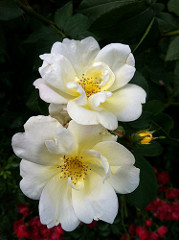

In [8]:
roses = list(data_dir.glob('roses/*'))
print(roses[0])
PIL.Image.open(str(roses[0]))

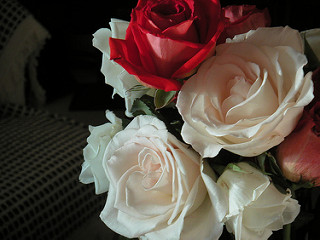

In [9]:
PIL.Image.open(str(roses[1]))

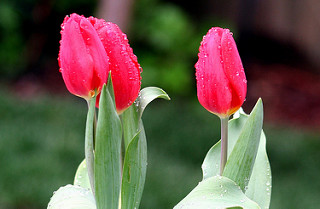

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

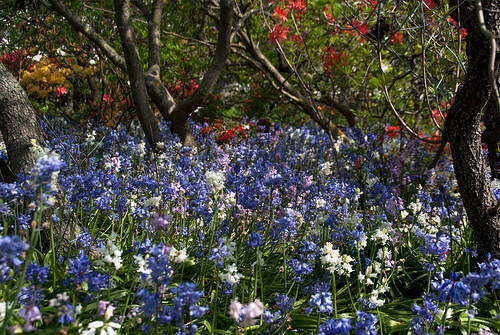

In [11]:
PIL.Image.open(str(tulips[1]))

# 2. Load using keras.preprocessing

In [12]:
batch_size = 32
img_height = 180
img_width = 180

### Create a dataset

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Visualize the dataset

In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


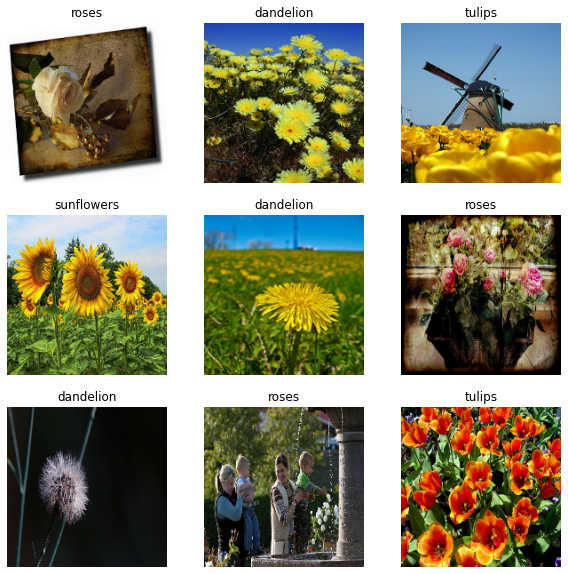

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalize the data by Rescaling layer

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalization_layer

มี 2 วิธีในการใช้เลเยอร์นี้ 

วิธีที่ 1 map เข้ากับ dataset

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


# 3. Create the model

วิธีที่ 2 ใส่เลเยอร์เข้าในโมเดล

In [21]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# 4. Train Model

In [24]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 11s 67ms/step - loss: 1.6202 - accuracy: 0.3006 - val_loss: 1.1159 - val_accuracy: 0.5368
Epoch 2/10
92/92 [==============================] - 3s 32ms/step - loss: 1.0378 - accuracy: 0.5978 - val_loss: 0.9649 - val_accuracy: 0.6117
Epoch 3/10
92/92 [==============================] - 3s 32ms/step - loss: 0.8153 - accuracy: 0.6867 - val_loss: 0.9020 - val_accuracy: 0.6608
Epoch 4/10
92/92 [==============================] - 3s 32ms/step - loss: 0.6090 - accuracy: 0.7824 - val_loss: 0.8791 - val_accuracy: 0.6608
Epoch 5/10
92/92 [==============================] - 3s 32ms/step - loss: 0.3684 - accuracy: 0.8843 - val_loss: 0.9972 - val_accuracy: 0.6390
Epoch 6/10
92/92 [==============================] - 3s 32ms/step - loss: 0.2310 - accuracy: 0.9277 - val_loss: 1.3725 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 3s 32ms/step - loss: 0.1356 - accuracy: 0.9581 - val_loss: 1.2797 - val_accuracy: 0.6349
Epoch 8/10
9

### Visualize training results

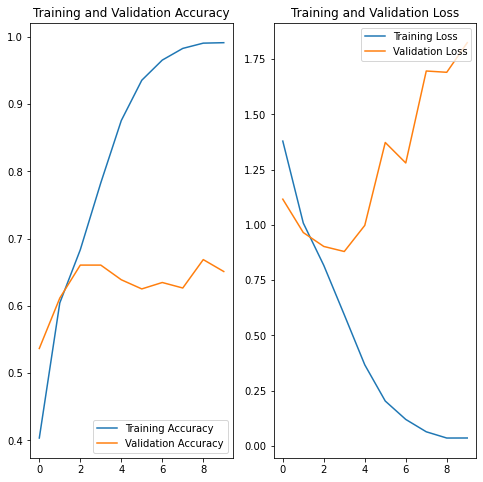

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data augmentation

In [26]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

### Visualize augmented results

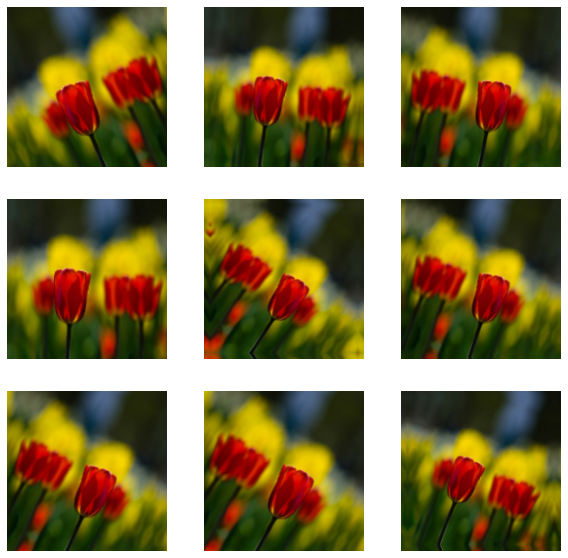

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# 5. Improve the model with Data augmentation and repeat the process

เพิ่มชั้น data_augmentation เข้าในโมเดล

In [28]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [31]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 4s 38ms/step - loss: 1.7387 - accuracy: 0.2662 - val_loss: 1.1618 - val_accuracy: 0.5123
Epoch 2/15
92/92 [==============================] - 3s 36ms/step - loss: 1.0952 - accuracy: 0.5527 - val_loss: 1.0456 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 3s 36ms/step - loss: 0.9619 - accuracy: 0.6198 - val_loss: 0.9737 - val_accuracy: 0.6199
Epoch 4/15
92/92 [==============================] - 3s 37ms/step - loss: 0.9264 - accuracy: 0.6264 - val_loss: 0.9745 - val_accuracy: 0.6185
Epoch 5/15
92/92 [==============================] - 3s 37ms/step - loss: 0.8386 - accuracy: 0.6764 - val_loss: 0.9755 - val_accuracy: 0.6335
Epoch 6/15
92/92 [==============================] - 3s 37ms/step - loss: 0.8117 - accuracy: 0.6967 - val_loss: 0.8289 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 3s 37ms/step - loss: 0.7616 - accuracy: 0.7135 - val_loss: 0.8658 - val_accuracy: 0.6703
Epoch 8/15
92

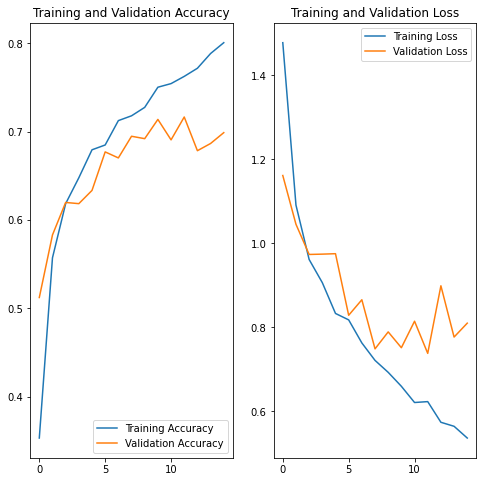

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 6. Test the model

In [33]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 97.88 percent confidence.
